In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.signal
import matplotlib.pyplot as plt
import pyxdf
import mne
import os
#%matplotlib qt

In [2]:
def xdf_to_dataframe(xdf_data):
    ''' Xdf Data should be a list of streams (dictionaries)
        Function returns a dictionary of dataframes, one dataframe per stream'''
    dataframes = {}
    for stream in xdf_data:
        df = pd.DataFrame()
        data = stream['time_series']
        timestamps = stream['time_stamps']
        df['Time'] = timestamps
        chan_names, units = get_channel_names(stream['info'])
        counts = data.shape[0]
        for series, name, unit in zip(range(data.shape[1]), chan_names, units):
            df[name[0]]  = data[:, series]
            if unit:
                df[name[0] + '_Unit'] = np.repeat(unit, counts)

        for item in stream['info']:
            if item not in ['name', 'desc', 'data']:
                try:
                    df[item] = np.repeat(stream['info'][item], counts)
                except:
                    continue
        dataframes[stream['info']['name'][0]] = df
    return dataframes

def get_channel_names(info):
    channels = info['desc'][0]['channels'][0]['channel']
    names = [chan['label'] for chan in channels ]
    units = [chan['unit'] for chan in channels ]
    return names, units

In [3]:
directory = 'Data'
participants = ['Jin']
xdf_files = ['Continuous_1.xdf','Continuous_2.xdf','Continuous_3.xdf','Fist_1.xdf', 'Fist_2.xdf','Fist_3.xdf', 'Left_20_1.xdf','Left_20_2.xdf','Left_20_3.xdf','Left_50_1.xdf','Left_50_2.xdf','Left_50_3.xdf','PalmUp_1.xdf','PalmUp_2.xdf','PalmUp_3.xdf','Right_30_1.xdf','Right_30_2.xdf','Right_30_3.xdf','Right_80_1.xdf','Right_80_2.xdf','Right_80_3.xdf',]
csv_files = ['Continuous_1.csv','Continuous_2.csv','Continuous_3..csv','Fist_1.csv', 'Fist_2.csv','Fist_3.csv', 'Left_20_1.csv','Left_20_2.csv','Left_20_3.csv','Left_50_1.csv','Left_50_2.csv','Left_50_3.csv','PalmUp_1.csv','PalmUp_2.csv','PalmUp_3.csv','Right_30_1.csv','Right_30_2.csv','Right_30_3.csv','Right_80_1.csv','Right_80_2.csv','Right_80_3.csv',]
for participant in participants:
    newfile = 0
    for file in xdf_files:
        data, header = pyxdf.load_xdf(os.path.join(directory, participant, file))
        data_dfs = xdf_to_dataframe(data)
        data_dfs['Thalmic Labs MyoMyo'].to_csv(os.path.join(directory, participant, csv_files[newfile]))
        myo_data = pd.read_csv(os.path.join(directory, participant, csv_files[newfile]))
        myo_data.columns = myo_data.columns.str.replace(' ', '')
        newfile += 1


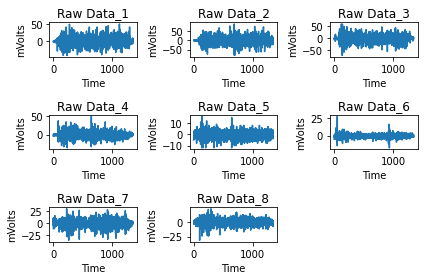

In [4]:
'''code used to look at 8 channels of raw data'''
import matplotlib.pyplot as plt
plt.figure()
for channel in range(1,9):
    plt.subplot(3,3,channel)
    ax = myo_data['EMG_' + str(channel)].plot()
    plt.title('Raw Data_' + str(channel))
    plt.ylabel('mVolts')
    plt.xlabel('Time')
    plt.tight_layout()

In [5]:
import scipy as sp
import scipy.signal

def filteremg(emg, low_pass=3, sfreq=200, high_band=20, low_band=95):
    # Zero mean emg signal
    emg = emg - emg.mean()
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(sfreq/2)
    low_band = low_band/(sfreq/2)
    # create bandpass filter for EMG
    b1, a1 = sp.signal.butter(4, [high_band,low_band], btype='bandpass', analog=True)
    # process EMG signal: filter EMG
    emg_filtered = sp.signal.filtfilt(b1, a1, emg)
    # process EMG signal: rectify
    emg_rectified = abs(emg_filtered)
    # create lowpass filter and apply to rectified signal to get EMG envelope
    #low_pass = low_pass/(sfreq/2)
    b2, a2 = sp.signal.butter(4, low_pass, fs=sfreq, btype='lowpass')
    emg_envelope = sp.signal.lfilter(b2, a2, emg_rectified)
    return emg_envelope

def notchfilter(emg, sfreq=256, notch_freq = 60, quality_factor = 20):
    b_notch, a_notch = sp.signal.iirnotch(notch_freq, quality_factor, sfreq)
    output = sp.signal.filtfilt(b_notch, a_notch, emg)
    return output

c:\users\jinhu\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


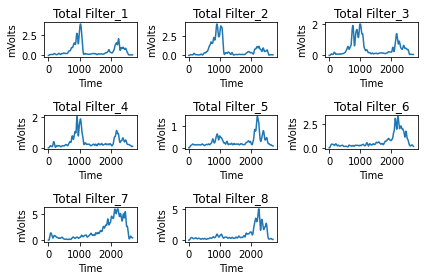

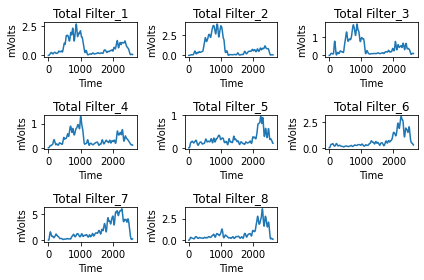

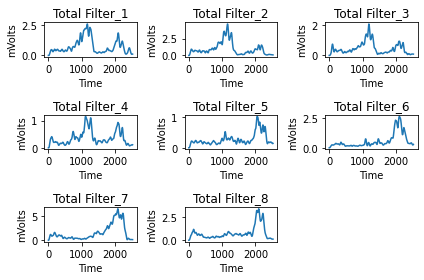

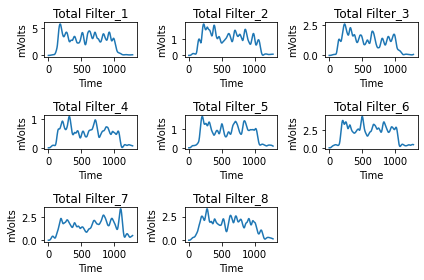

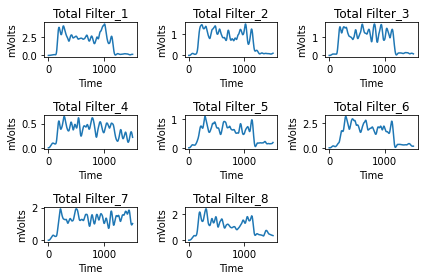

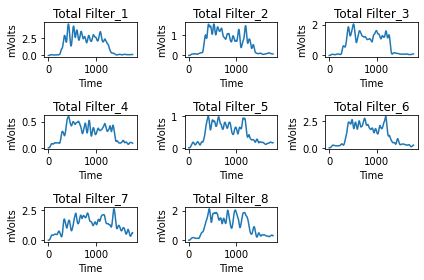

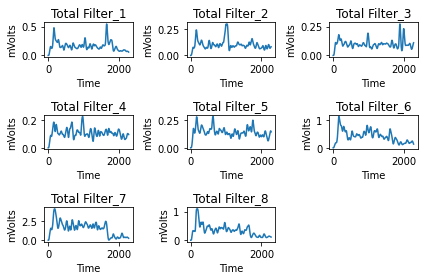

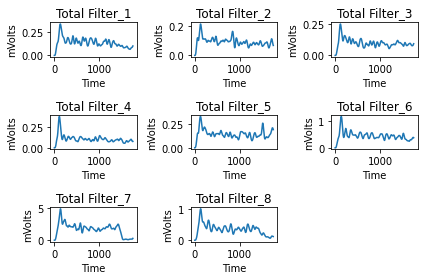

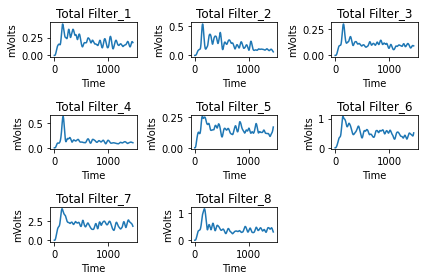

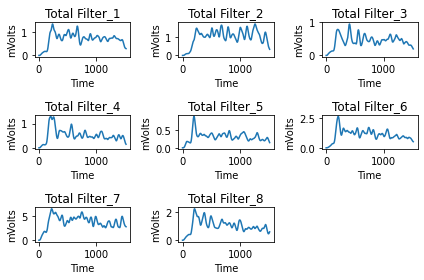

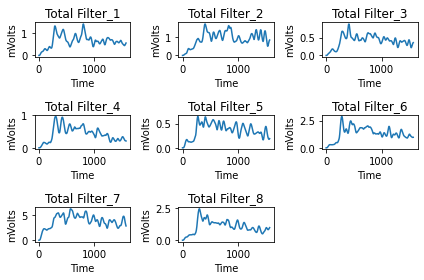

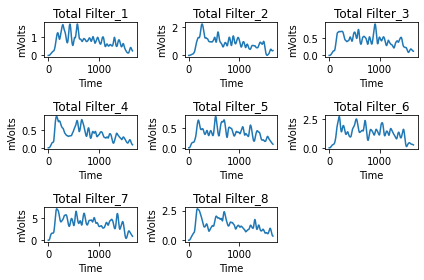

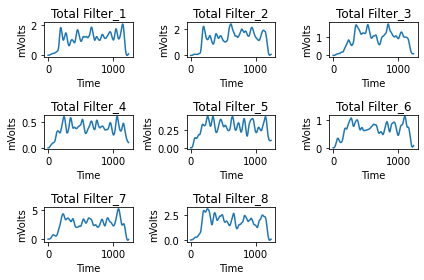

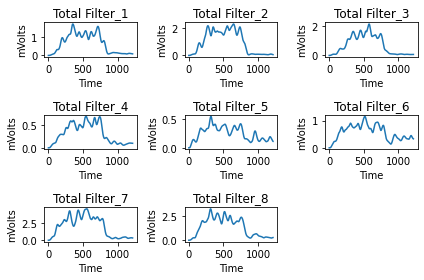

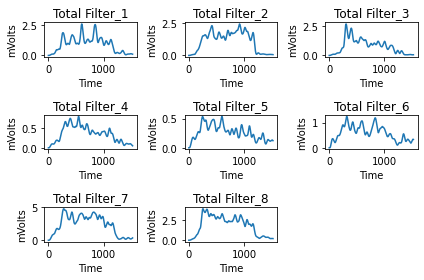

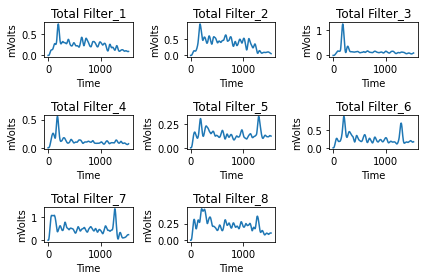

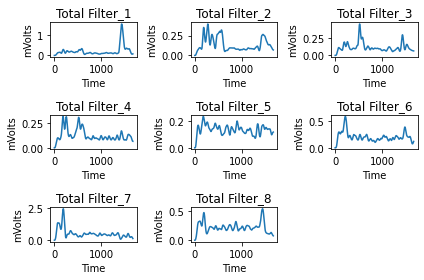

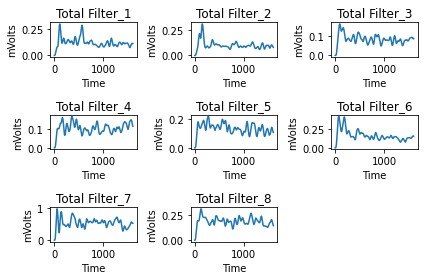

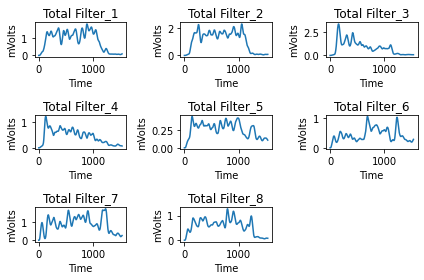

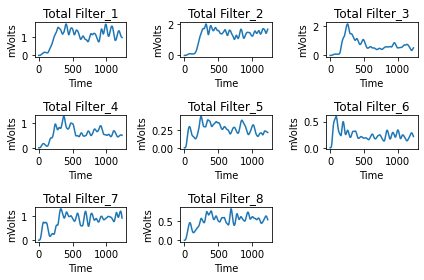

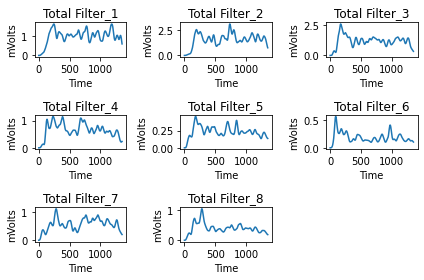

In [6]:
for participant in participants:
    newfile = 0
    for file in xdf_files:
        myo_data = pd.read_csv(os.path.join(directory, participant, csv_files[newfile]))
        myo_filtered = myo_data.copy()
        myo_data_keys = ['EMG_' + str(i) for i in range(1, 9)] #for bio its range (1,5)
        myo_filtered[myo_data_keys] = myo_filtered[myo_data_keys].apply(filteremg, sfreq = 256, high_band=20, low_band=95, raw=True)
        myo_notch = myo_filtered.copy()
        myo_data_keys = ['EMG_' + str(i) for i in range(1, 9)] #for bio its ran3ge (1,5)
        myo_notch[myo_data_keys] = myo_notch[myo_data_keys].apply(notchfilter, raw=True)
        #myo_notch.plot_psd(area_mode='range', tmax=10.0, show=False, average=True)
        plt.figure()
        for channel in range(1,9):
            plt.subplot(3,3,channel)
            ax = myo_notch['EMG_' + str(channel)].plot()
            plt.title('Total Filter_' + str(channel))
            plt.ylabel('mVolts')
            plt.xlabel('Time')
            plt.tight_layout()
        newfile += 1

In [37]:
'''Extract the PSD and find the Max Power of each sample and signal'''
PSD=[]
TempRow = []
for participant in participants:
    newfile = 0
    for file in xdf_files:
        myo_data = pd.read_csv(os.path.join(directory, participant, csv_files[newfile]))
        myo_filtered = myo_data.copy()
        myo_data_keys = ['EMG_' + str(i) for i in range(1, 9)] #for bio its range (1,5)
        myo_filtered[myo_data_keys] = myo_filtered[myo_data_keys].apply(filteremg, sfreq = 256, high_band=20, low_band=95, raw=True)
        myo_notch = myo_filtered.copy()
        myo_data_keys = ['EMG_' + str(i) for i in range(1, 9)] #for bio its ran3ge (1,5)
        myo_notch[myo_data_keys] = myo_notch[myo_data_keys].apply(notchfilter, raw=True)
        #myo_notch.plot_psd(area_mode='range', tmax=10.0, show=False, average=True)

        '''Copy the myo_notch files'''
        myo_PSD = myo_notch.copy() #Copy the notched data into PSD
        #myo_data_keys = ['EMG_' + str(i) for i in range(1, 9)] #for bio its ran3ge (1,5)
        for channel in range(1,9):
            Freq, P_Den = sp.signal.periodogram(myo_PSD['EMG_'+str(channel)],200)
            bigP_Den = max(P_Den)
            T_bigP_Den = np.transpose(bigP_Den)
            TempRow.append(T_bigP_Den)
            '''This get all 8 channel max PSD'''
        newfile += 1
        #display(TempRow)
        PSD.append([TempRow])
        TempRow = [] #Reset the TempRow
#display(TempRow)
display(PSD)


[[[3.6574058661965765,
   5.286873356462931,
   1.876386369712331,
   0.9962514151135385,
   0.36443342014321334,
   3.300803431122582,
   27.858800659936968,
   4.846876356394396]],
 [[3.186482349147128,
   7.013025428951172,
   1.1807535396221553,
   0.4803257997432123,
   0.1653737050980301,
   3.208704761308637,
   23.227835007921644,
   2.811764735622135]],
 [[1.5243458014849285,
   3.7750542411209307,
   0.6030470440499313,
   0.2018139933328453,
   0.12343439209937075,
   1.9529630430938392,
   18.60494235070586,
   1.8882342076985794]],
 [[7.65240881534942,
   0.8704797905149211,
   1.2533938759736323,
   0.1631265159691287,
   0.5248805651242405,
   4.889725124042598,
   1.2588198987797037,
   2.0363232345865874]],
 [[5.993175418859608,
   0.9166236394664811,
   1.37058940900439,
   0.06492881016406925,
   0.3711084669958905,
   4.699207685262025,
   0.2579978026709034,
   0.8257400479213525]],
 [[11.189907883441471,
   1.4308586723636474,
   2.4693405900627545,
   0.133656716

In [ ]:
#pca

#svm
#kmeans

#rf rand forest

#confusion matrix
#accuracy